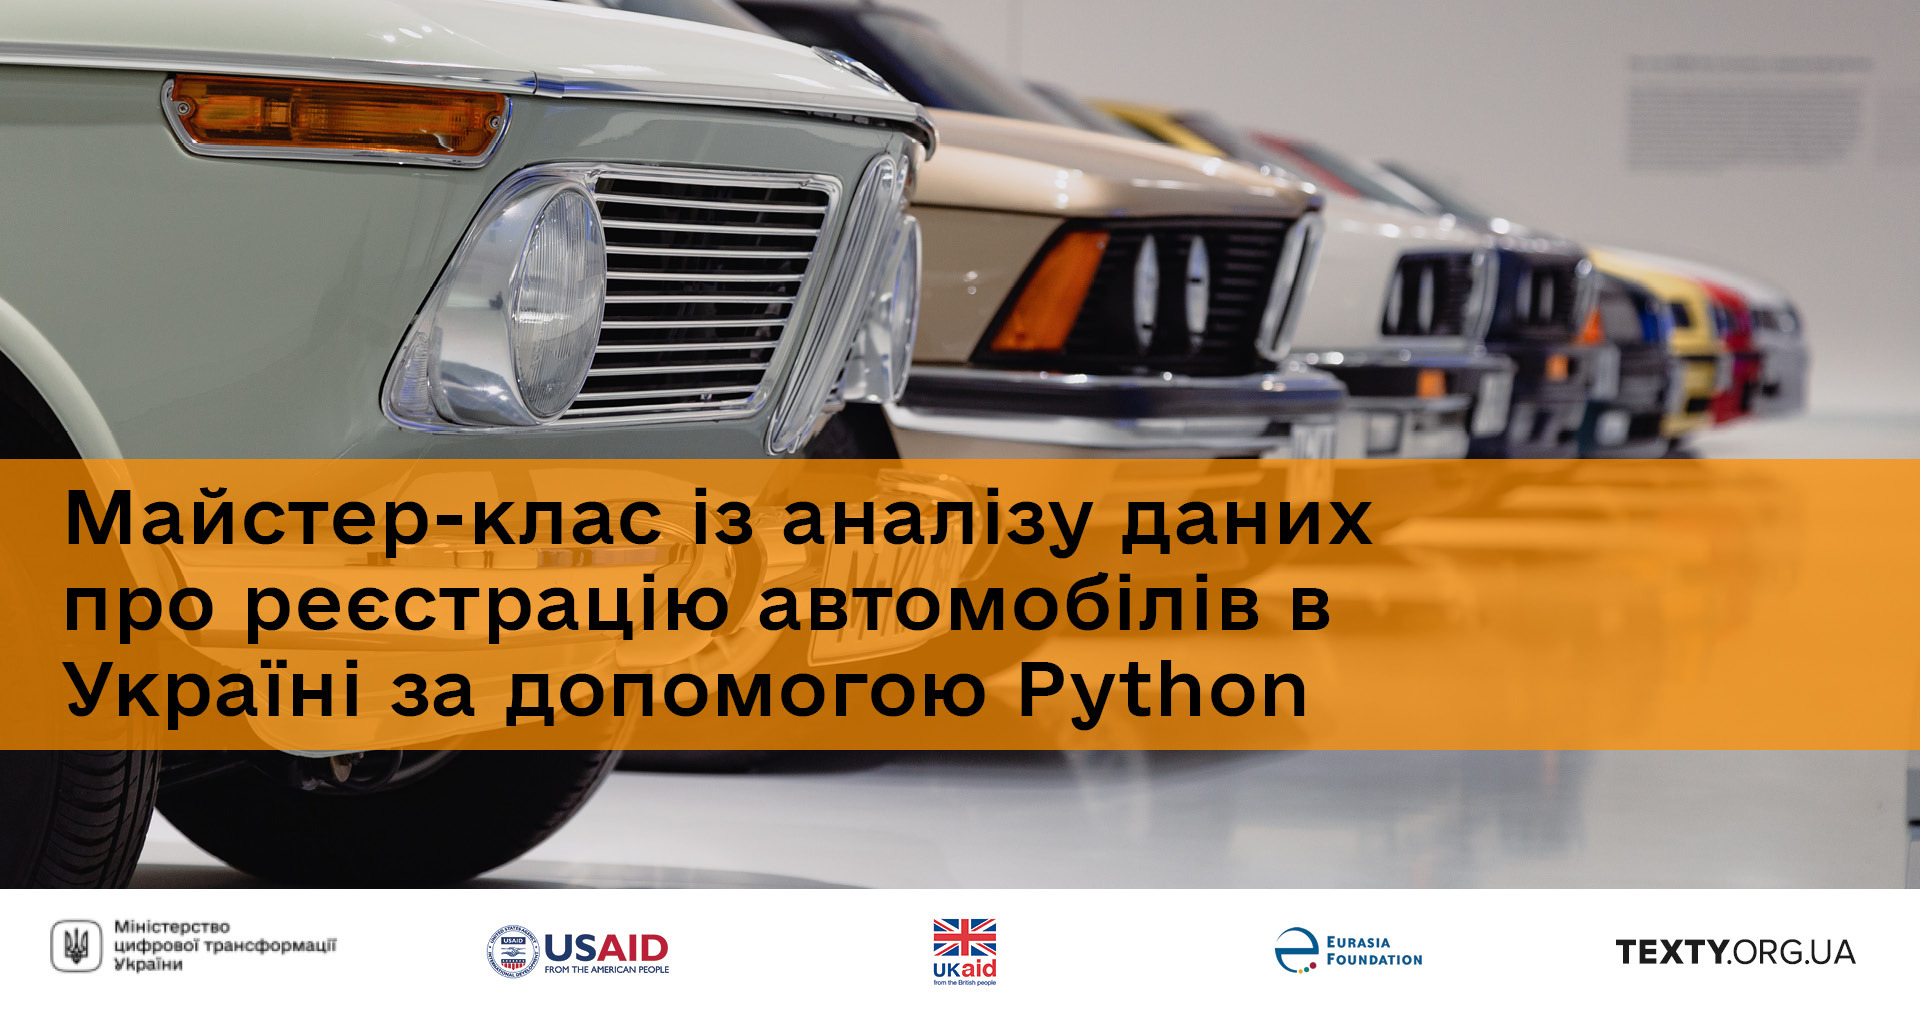

<font size = 5>Більше про відкриті дані: </font> 

https://docs.google.com/presentation/d/1t9ATBb3Y9YQDZA9ctpNVAVt2AVbncxqPAZRtjBZZ-GQ/edit?usp=sharing

<font size = 5>Набір даних:</font> 

https://data.gov.ua/dataset/06779371-308f-42d7-895e-5a39833375f0

<font size = 5>__Що ми можемо дізнатись__:</font> 
    <ul>
     <li>топ реєстрацій автомобілів за маркою;</li>
        <li>топ реєстрацій автомобілів за моделлю</li>
        <li>кількість реєстрацій авто по країні</li>
        <li>кількість реєстрацій авто по областях</li>
    </ul>

<font size = 5>__Імпортуємо бібілотеки__ </font>

In [2]:
import requests # робимо запити по url
import json # для роботи із json файлами
import pandas as pd # основна бібілотека для роботи із даними
import numpy as np # для роботи із матрицями, веторами та масивами
from matplotlib import pyplot as plt # бібліотека для побудови графіків
from pprint import pprint as pp # бібліотека для людиночитаного представлення даних 
import re # бібліотека для робот із регулярними виразами
import seaborn as sns # надбудова для спрошення побудови графіків
import csv # бібліотека для роботи із csv файлами
import io # модуль із командами для взаємодіїі із різними типами файлів
import zipfile # бібліотека для роботи із .zip файлами
import os # бібліотека для взаємодії із системою
from tqdm import tqdm # звичайний прогрес бар

# Працюємо із АРІ порталу

<font size = 5>__Робимо запит до АРІ Data.gov.ua__</font>

__документація по роботі із АРІ Порталу:__ https://data.gov.ua/pages/aboutuser2

__ідентифікаційний номер набору даних по реєстрації авто в Україні:__ 	06779371-308f-42d7-895e-5a39833375f0

__посилання на набір даних:__ https://data.gov.ua/dataset/06779371-308f-42d7-895e-5a39833375f0

In [2]:
response = requests.get("https://data.gov.ua/api/3/action/package_show?id=06779371-308f-42d7-895e-5a39833375f0").json()

In [3]:
# звичайний метож не надто ефективний в такому випадку
print(response)

{'help': 'https://data.gov.ua/api/3/action/help_show?name=package_show', 'success': True, 'result': {'license_title': 'Creative Commons Attribution', 'maintainer': 'Кішман Назарій Костянтинович', 'relationships_as_object': [], 'tag_string': 'транспортні,автомобілі,власники,реєстр,засоби,автомобіль,тз,колісні,власник', 'purpose_of_collecting_information': 'Закону України “Про дорожній рух”', 'private': False, 'maintainer_email': 'n.kishman@hsc.gov.ua', 'num_tags': 9, 'update_frequency': 'once a month', 'id': '0ffd8b75-0628-48cc-952a-9302f9799ec0', 'metadata_created': '2018-08-22T14:52:50.808591', 'metadata_modified': '2021-05-05T07:06:41.350943', 'author': 'rodger_236', 'author_email': 'rodger@mvs.gov.ua', 'state': 'active', 'version': '1.0', 'archiver': {'status': 'Archived successfully', 'is_broken': False, 'reason': '', 'status_id': 0}, 'is_datapackage': 'true', 'creator_user_id': '109cb3b1-5415-4457-8280-f927e9cc5335', 'type': 'dataset', 'resources': [{'cache_last_updated': None, 'p

In [4]:
# краще спрацьовує модуль pprint https://docs.python.org/3/library/pprint.html
pp(response) #переглядаємо вміст відповіді

{'help': 'https://data.gov.ua/api/3/action/help_show?name=package_show',
 'result': {'archiver': {'is_broken': False,
                         'reason': '',
                         'status': 'Archived successfully',
                         'status_id': 0},
            'author': 'rodger_236',
            'author_email': 'rodger@mvs.gov.ua',
            'creator_user_id': '109cb3b1-5415-4457-8280-f927e9cc5335',
            'groups': [{'description': 'Все що стосується Верховної ради та '
                                       'питань загальнодаржавного характеру',
                        'display_name': 'Держава',
                        'id': '6c734e97-52f5-40a1-9cb5-81b5ebb15e43',
                        'image_display_url': 'https://data.gov.ua/uploads/group/2018-08-09-052819.023276bank-2.svg',
                        'name': 'derzhava',
                        'title': 'Держава'},
                       {'description': 'Арештоване Майно, все про компанії, '
                        

Нам треба знайти дані із атрибутом "url_redirected_to" повний шлях: "["result"]["resources"][_порядковий номер ресурсу_]["url"]"
Отримуємо дані за допомогою циклу, яким перебираємо всі посилання на ресурси у наборі.

In [5]:
for i in response["result"]["resources"]:
    print(i["description"], " :", i["url"]) # можна використовувати +, але протыше використовувати кому

Дані щодо транспортних засобів за 2018 рік  : https://data.gov.ua/dataset/0ffd8b75-0628-48cc-952a-9302f9799ec0/resource/01323740-88df-46c2-b06e-fbb58c89fe17/download/tz_opendata_z01012018_po01012019.zip
Дані щодо транспортних засобів за 2017 рік  : https://data.gov.ua/dataset/0ffd8b75-0628-48cc-952a-9302f9799ec0/resource/9ce32352-bd11-4324-a2b4-5addbd228b1b/download/tz_opendata_z01012017_po31122017.zip
Дані щодо транспортних засобів за 2016 рік  : https://data.gov.ua/dataset/0ffd8b75-0628-48cc-952a-9302f9799ec0/resource/7bdc2a1b-5399-4ab0-97e0-633e68837b04/download/tz_opendata_z01012016_po31122016.zip
Дані щодо транспортних засобів за 2015 рік  : https://data.gov.ua/dataset/0ffd8b75-0628-48cc-952a-9302f9799ec0/resource/09c606dc-d740-40db-96f0-e679eeca6ace/download/tz_opendata_z01012015_po31122015.zip
Дані щодо транспортних засобів за 2014 рік  : https://data.gov.ua/dataset/0ffd8b75-0628-48cc-952a-9302f9799ec0/resource/80a115ae-61df-4a13-8771-36c2826268df/download/tz_opendata_z01012014_

In [6]:
# циклом збираємо url адреси
urls = [i["url"] for i in response["result"]["resources"]]
urls

['https://data.gov.ua/dataset/0ffd8b75-0628-48cc-952a-9302f9799ec0/resource/01323740-88df-46c2-b06e-fbb58c89fe17/download/tz_opendata_z01012018_po01012019.zip',
 'https://data.gov.ua/dataset/0ffd8b75-0628-48cc-952a-9302f9799ec0/resource/9ce32352-bd11-4324-a2b4-5addbd228b1b/download/tz_opendata_z01012017_po31122017.zip',
 'https://data.gov.ua/dataset/0ffd8b75-0628-48cc-952a-9302f9799ec0/resource/7bdc2a1b-5399-4ab0-97e0-633e68837b04/download/tz_opendata_z01012016_po31122016.zip',
 'https://data.gov.ua/dataset/0ffd8b75-0628-48cc-952a-9302f9799ec0/resource/09c606dc-d740-40db-96f0-e679eeca6ace/download/tz_opendata_z01012015_po31122015.zip',
 'https://data.gov.ua/dataset/0ffd8b75-0628-48cc-952a-9302f9799ec0/resource/80a115ae-61df-4a13-8771-36c2826268df/download/tz_opendata_z01012014_po31122014.zip',
 'https://data.gov.ua/dataset/0ffd8b75-0628-48cc-952a-9302f9799ec0/resource/86a9548b-8323-4fa2-972e-0692edf6959f/download/tz_opendata_z01012013_po31122013.zip',
 'https://data.gov.ua/dataset/0ffd

In [7]:
# створюємо папку "data", якщо папка існує отримаємо помилку
os.mkdir("data")

FileExistsError: [WinError 183] Невозможно создать файл, так как он уже существует: 'data'

In [ ]:
# за допомогою запитів збираємо архіви розпакрвуємо їх та складаємо в папку
for url in urls:
    response = requests.get(url)
    zip_data = io.BytesIO(response.content)
    # розпаковуємо архів із даними
    print("zip_data = io.BytesIO(rs.content)")
    with zipfile.ZipFile(zip_data) as zip_file:
        print("zip_file.extractall")
        zip_file.extractall("data")

Отримуємо перелік всіх файлів в директорії

In [8]:
# складаємо перелік файлів в змінну та викликаємо її
directory = os.listdir("data")
directory

['tz_opendata_z01012013_po31122013.csv',
 'tz_opendata_z01012014_po31122014.csv',
 'tz_opendata_z01012015_po31122015.csv',
 'tz_opendata_z01012016_po31122016.csv',
 'tz_opendata_z01012017_po31122017.csv',
 'tz_opendata_z01012018_po01012019.csv',
 'tz_opendata_z01012019_po01012020.csv',
 'tz_opendata_z01012020_po01012021.csv',
 'tz_opendata_z01012021_po01042021.csv']

# Підвантажєння та підготовка даних

## Перекодовуємо інформацію про області та сервісні центри

In [10]:
# тестуємо завантаження даних
# вимикаємо сповіщення про помилки та примусово зазначаємо роздільник
# досліджуємо датасет
data = pd.read_csv("data/tz_opendata_z01012013_po31122013.csv", error_bad_lines = False, sep = ";")
data

,person,reg_addr_koatuu,oper_code,oper_name,d_reg,dep_code,dep,brand,model,make_year,color,kind,body,purpose,fuel,capacity,own_weight,total_weight,n_reg_new
0,P,5.101370e+08,40,"40 - ВТОРИННА РЕЄСТРАЦІЯ ТЗ, ПРИДБАНОГО В ТОРГ...",2013-01-16,1305301,ВІННИЦЬКИЙ ВРЕР УДАІ УМВС УКРАЇНИ У ВІННИЦЬКІ...,SSANG YONG REXTON,REXTON,2007,ЧОРНИЙ,ЛЕГКОВИЙ,УНІВЕРСАЛ-B,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,2696.0,2069.0,2550.0,АВ1923ВТ
1,P,5.110137e+09,230,230 - ВИДАЧА СВ. ПРО РЕЄСТР ДЛЯ ПОЇЗДКИ ЗА КО...,2013-08-29,5146,Центр 5146,TOYOTA PREVIA,PREVIA,2007,СІРИЙ,ЛЕГКОВИЙ,УНІВЕРСАЛ-B,ЗАГАЛЬНИЙ,БЕНЗИН,2362.0,1720.0,2450.0,ВН8542СО
2,P,2.310137e+09,40,"40 - ВТОРИННА РЕЄСТРАЦІЯ ТЗ, ПРИДБАНОГО В ТОРГ...",2013-02-02,1242,Центр 1242,SKODA OCTAVIA,OCTAVIA,2011,БІЛИЙ,ЛЕГКОВИЙ,ХЕТЧБЕК-В,ЗАГАЛЬНИЙ,БЕНЗИН,1595.0,1245.0,1720.0,АР6199СІ
3,P,6.110100e+09,400,400 - ПЕРЕРЕЄСТРАЦIЯ ПРИ ПЕРЕОБЛАДНАННI БЕЗ ЗА...,2013-01-26,6141,Центр 6141,CITROEN JUMPY,JUMPY,2008,БІЛИЙ,ЛЕГКОВИЙ,ПАСАЖИРСЬКИЙ-B,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,1560.0,1736.0,2661.0,ВО5930ВА
4,P,6.110100e+09,400,400 - ПЕРЕРЕЄСТРАЦIЯ ПРИ ПЕРЕОБЛАДНАННI БЕЗ ЗА...,2013-01-05,6141,Центр 6141,MERCEDES-BENZ SPRINTER 313 CDI,SPRINTER 313 CDI,2005,БІЛИЙ,ЛЕГКОВИЙ,ПАСАЖИРСЬКИЙ-B,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,2148.0,1995.0,3500.0,ВО5562ВА
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1935491,P,1.210137e+09,100,100 - ПЕРВИННА РЕЄСТРАЦIЯ ТЗ ПРИДБАНОГО В ТОРГ...,2013-03-28,1242,Центр 1242,MITSUBISHI OUTLANDER,OUTLANDER,2013,СИНІЙ,ЛЕГКОВИЙ,УНІВЕРСАЛ-B,ЗАГАЛЬНИЙ,БЕНЗИН,2360.0,1634.0,1985.0,АЕ0444НЕ
1935492,P,6.110100e+09,40,"40 - ВТОРИННА РЕЄСТРАЦІЯ ТЗ, ПРИДБАНОГО В ТОРГ...",2013-08-31,6141,Центр 6141,OPEL MOVANO,MOVANO,2008,БІЛИЙ,ВАНТАЖНИЙ,ФУРГОН МАЛОТОНАЖНИЙ-B,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,2464.0,1893.0,3500.0,ВО7384ВВ
1935493,P,7.320784e+09,69,69 - РЕЄСТРАЦІЯ ТЗ ПО АКТУ ПРИЙОМУ-ПЕРЕДАЧІ,2013-01-30,7341,Центр 7341,ГАЗ 3302 АХІ-1,3302 АХІ-1,2012,БІЛИЙ,ВАНТАЖНИЙ,ФУРГОН,СПЕЦІАЛІЗОВАНИЙ,БЕНЗИН,2890.0,2300.0,3500.0,СЕ2013ВВ
1935494,P,1.410600e+09,40,"40 - ВТОРИННА РЕЄСТРАЦІЯ ТЗ, ПРИДБАНОГО В ТОРГ...",2013-08-27,4841,Центр 4841,FIAT DOBLO,DOBLO,2008,СІРИЙ,ЛЕГКОВИЙ,ПАСАЖИРСЬКИЙ-B,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,1910.0,1190.0,2115.0,АН3315ІІ


In [13]:
# циклом завантажуємо кожен окремий файл та додаємо його до датасету - pd.concat
data_wrong = pd.DataFrame()
for f in tqdm(directory):
    table = pd.read_csv("data/"+ str(f), error_bad_lines = False, sep = ";")
    data_wrong= pd.concat([data_wrong, table])
data_wrong

 67%|████████████████████████████████████████████████████████                            | 6/9 [03:22<01:27, 29.23s/it]c:\users\dhuba\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [03:54<01:00, 30.17s/it]c:\users\dhuba\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [04:45<00:00, 31.75s/it]


,person,reg_addr_koatuu,oper_code,oper_name,d_reg,dep_code,dep,brand,model,make_year,...,MAKE_YEAR,COLOR,KIND,BODY,PURPOSE,FUEL,CAPACITY,OWN_WEIGHT,TOTAL_WEIGHT,N_REG_NEW
0,P,5.101370e+08,40.0,"40 - ВТОРИННА РЕЄСТРАЦІЯ ТЗ, ПРИДБАНОГО В ТОРГ...",2013-01-16,1305301.0,ВІННИЦЬКИЙ ВРЕР УДАІ УМВС УКРАЇНИ У ВІННИЦЬКІ...,SSANG YONG REXTON,REXTON,2007.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,P,5.110137e+09,230.0,230 - ВИДАЧА СВ. ПРО РЕЄСТР ДЛЯ ПОЇЗДКИ ЗА КО...,2013-08-29,5146.0,Центр 5146,TOYOTA PREVIA,PREVIA,2007.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,P,2.310137e+09,40.0,"40 - ВТОРИННА РЕЄСТРАЦІЯ ТЗ, ПРИДБАНОГО В ТОРГ...",2013-02-02,1242.0,Центр 1242,SKODA OCTAVIA,OCTAVIA,2011.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,P,6.110100e+09,400.0,400 - ПЕРЕРЕЄСТРАЦIЯ ПРИ ПЕРЕОБЛАДНАННI БЕЗ ЗА...,2013-01-26,6141.0,Центр 6141,CITROEN JUMPY,JUMPY,2008.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,P,6.110100e+09,400.0,400 - ПЕРЕРЕЄСТРАЦIЯ ПРИ ПЕРЕОБЛАДНАННI БЕЗ ЗА...,2013-01-05,6141.0,Центр 6141,MERCEDES-BENZ SPRINTER 313 CDI,SPRINTER 313 CDI,2005.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443461,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2002.0,СІРИЙ,ЛЕГКОВИЙ,УНІВЕРСАЛ,ЗАГАЛЬНИЙ,БЕНЗИН,1595.0,1295,1805,ВХ8612ЕО
443462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2007.0,ЧОРНИЙ,ЛЕГКОВИЙ,УНІВЕРСАЛ,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,2188.0,2030,2570,АВ5529НО
443463,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2007.0,ЧОРНИЙ,ЛЕГКОВИЙ,УНІВЕРСАЛ,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,2188.0,2030,2570,АВ0875НТ
443464,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2014.0,БІЛИЙ,ЛЕГКОВИЙ,УНІВЕРСАЛ,ЗАГАЛЬНИЙ,ЕЛЕКТРО АБО БЕНЗИН,2000.0,1674,2250,АН4178ОН


In [17]:
# якщо переглянемо колонки то побачимо, що через різний регістр назв ми отримали неправильний масив
data_wrong.columns

Index(['person', 'reg_addr_koatuu', 'oper_code', 'oper_name', 'd_reg',
       'dep_code', 'dep', 'brand', 'model', 'make_year', 'color', 'kind',
       'body', 'purpose', 'fuel', 'capacity', 'own_weight', 'total_weight',
       'n_reg_new', 'PERSON', 'REG_ADDR_KOATUU', 'OPER_CODE', 'OPER_NAME',
       'D_REG', 'DEP_CODE', 'DEP', 'BRAND', 'MODEL', 'MAKE_YEAR', 'COLOR',
       'KIND', 'BODY', 'PURPOSE', 'FUEL', 'CAPACITY', 'OWN_WEIGHT',
       'TOTAL_WEIGHT', 'N_REG_NEW'],
      dtype='object')

In [19]:
# правильний спосіб завантаження даних в pandas, якщов они зберігаються у кількох таблицях
data_right = pd.DataFrame()
for f in tqdm(directory):
    table = pd.read_csv("data/"+ str(f), error_bad_lines = False, sep = ";")
    table.columns = table.columns.str.lower() #у деяких старих наборах даних заголовки колонок великими літерами
    data_right = pd.concat([data_right, table])
data_right

 67%|████████████████████████████████████████████████████████                            | 6/9 [01:04<00:32, 10.90s/it]c:\users\dhuba\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [01:21<00:25, 12.92s/it]c:\users\dhuba\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:47<00:00, 11.91s/it]


,person,reg_addr_koatuu,oper_code,oper_name,d_reg,dep_code,dep,brand,model,make_year,color,kind,body,purpose,fuel,capacity,own_weight,total_weight,n_reg_new
0,P,5.101370e+08,40,"40 - ВТОРИННА РЕЄСТРАЦІЯ ТЗ, ПРИДБАНОГО В ТОРГ...",2013-01-16,1305301,ВІННИЦЬКИЙ ВРЕР УДАІ УМВС УКРАЇНИ У ВІННИЦЬКІ...,SSANG YONG REXTON,REXTON,2007,ЧОРНИЙ,ЛЕГКОВИЙ,УНІВЕРСАЛ-B,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,2696.0,2069.0,2550.0,АВ1923ВТ
1,P,5.110137e+09,230,230 - ВИДАЧА СВ. ПРО РЕЄСТР ДЛЯ ПОЇЗДКИ ЗА КО...,2013-08-29,5146,Центр 5146,TOYOTA PREVIA,PREVIA,2007,СІРИЙ,ЛЕГКОВИЙ,УНІВЕРСАЛ-B,ЗАГАЛЬНИЙ,БЕНЗИН,2362.0,1720.0,2450.0,ВН8542СО
2,P,2.310137e+09,40,"40 - ВТОРИННА РЕЄСТРАЦІЯ ТЗ, ПРИДБАНОГО В ТОРГ...",2013-02-02,1242,Центр 1242,SKODA OCTAVIA,OCTAVIA,2011,БІЛИЙ,ЛЕГКОВИЙ,ХЕТЧБЕК-В,ЗАГАЛЬНИЙ,БЕНЗИН,1595.0,1245.0,1720.0,АР6199СІ
3,P,6.110100e+09,400,400 - ПЕРЕРЕЄСТРАЦIЯ ПРИ ПЕРЕОБЛАДНАННI БЕЗ ЗА...,2013-01-26,6141,Центр 6141,CITROEN JUMPY,JUMPY,2008,БІЛИЙ,ЛЕГКОВИЙ,ПАСАЖИРСЬКИЙ-B,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,1560.0,1736.0,2661.0,ВО5930ВА
4,P,6.110100e+09,400,400 - ПЕРЕРЕЄСТРАЦIЯ ПРИ ПЕРЕОБЛАДНАННI БЕЗ ЗА...,2013-01-05,6141,Центр 6141,MERCEDES-BENZ SPRINTER 313 CDI,SPRINTER 313 CDI,2005,БІЛИЙ,ЛЕГКОВИЙ,ПАСАЖИРСЬКИЙ-B,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,2148.0,1995.0,3500.0,ВО5562ВА
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443461,P,NaN,71,РЕЄСТРАЦІЯ ТЗ ПРИВЕЗЕНОГО З-ЗА КОРДОНУ ПО ПОСВ...,05.03.2021,12373,ТСЦ 6843,SKODA,OCTAVIA COMBI,2002,СІРИЙ,ЛЕГКОВИЙ,УНІВЕРСАЛ,ЗАГАЛЬНИЙ,БЕНЗИН,1595.0,1295,1805,ВХ8612ЕО
443462,P,5.104000e+08,308,ПЕРЕРЕЄСТРАЦІЯ НА НОВОГО ВЛАСНИКА ЗА ДОГ. КУПI...,16.03.2021,12231,ТСЦ 0543,HYUNDAI,SANTA FE,2007,ЧОРНИЙ,ЛЕГКОВИЙ,УНІВЕРСАЛ,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,2188.0,2030,2570,АВ5529НО
443463,P,5.101000e+08,71,РЕЄСТРАЦІЯ ТЗ ПРИВЕЗЕНОГО З-ЗА КОРДОНУ ПО ПОСВ...,05.03.2021,12229,ТСЦ 0541,HYUNDAI,SANTA FE,2007,ЧОРНИЙ,ЛЕГКОВИЙ,УНІВЕРСАЛ,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,2188.0,2030,2570,АВ0875НТ
443464,P,NaN,308,ПЕРЕРЕЄСТРАЦІЯ НА НОВОГО ВЛАСНИКА ЗА ДОГ. КУПI...,30.03.2021,12250,ТСЦ 1443,FORD,C-MAX,2014,БІЛИЙ,ЛЕГКОВИЙ,УНІВЕРСАЛ,ЗАГАЛЬНИЙ,ЕЛЕКТРО АБО БЕНЗИН,2000.0,1674,2250,АН4178ОН


In [21]:
data_right.columns

Index(['person', 'reg_addr_koatuu', 'oper_code', 'oper_name', 'd_reg',
       'dep_code', 'dep', 'brand', 'model', 'make_year', 'color', 'kind',
       'body', 'purpose', 'fuel', 'capacity', 'own_weight', 'total_weight',
       'n_reg_new'],
      dtype='object')

In [38]:
# очищуємо зайві перемінні для економії пам'яті
del data_right
del data_wrong

Дані із кодами КОАТУУ - частково не заповнені, ми не хочемо втратити інформацію про жодну зареєстровану дію, тому ми не будемо використовувати дані із атрибуту data["reg_addr_koatuu"], натомість ми геокодуємо дані з інформації про орган, який здійснював реєстраційні дії. Але ці дані доволі брудні, також під час формування набору у 2013 - 2015 роках проховодилась реформа, що призвело до того, що ми маємо інформацію про різні органи реєстрації. Сучасні органи кодуються у форматі ТСЦ ххуу - де хх - код регіону, а уу - унікальний код сервісного центру. 
Завантажимо таблицю, яка містить інформацію про сучасну прив'язку ТСЦ до областей та виведемо її, для цього треба налаштувати Pandas

In [2]:
# встановлення обмеження на кількість відображених рядків
pd.set_option('display.max_rows', 160)
 
# скидання обмеження на кількість відображених атрибутів
pd.set_option('display.max_columns', None)
 
# встановлення обмеження на кількість відображених символів в комірці
pd.set_option('display.max_colwidth', 25)

In [23]:
# читаємо таблицю
deps = pd.read_excel("dep.xlsx")

In [24]:
# виводимо її на екран для ознайомлення
deps

,dep,region
0,ТСЦ 0541,Вінницька
1,ТСЦ 0544,Вінницька
2,ТСЦ 0545,Вінницька
3,ТСЦ 0546,Вінницька
4,ТСЦ 0741,Волинська
5,ТСЦ 0742,Волинська
6,ТСЦ 0743,Волинська
7,ТСЦ 0744,Волинська
8,ТСЦ 1241,Дніпропетровська
9,ТСЦ 1242,Дніпропетровська


In [25]:
# дублюємо колонку із даними про департаменти для подальшого кодування регіонів
data["region"] = data["dep"]

In [26]:
# зводимо все до нижнього регістру
data["region"] = data["region"].str.lower()

# стандартизуємо дані із назвами сервісних центрів

data["region"] = data["region"].str.replace(r"\((\d{4})\).*", r"тсц \1", regex=True)
# Для быльшої зрозумілості виокремити області вирішив через окремі ітерації
data["region"] = data["region"].str.replace(r".*макарі.*|.*київсь.*", r"київська", regex=True)
data["region"] = data["region"].str.replace(r".*чернівець.*", r"чернівецька", regex=True)
data["region"] = data["region"].str.replace(r".*херсон.*", r"херсонська", regex=True)
data["region"] = data["region"].str.replace(r".*мог-подільськ.*|.*липовец.*|.*ямпіл.*|.*калинівс.*|.*тульчин.*|.*козятин.*|.*вінниць.*|.*жмерин.*|.*берша.*|.*крижо.*|.*хмільн.*|.*гайсин.*|.*немирів.*", r"вінницька", regex=True)
data["region"] = data["region"].str.replace(r".*донець.*", r"донецька", regex=True)
data["region"] = data["region"].str.replace(r".*тернопіль.*", r"тернопільська", regex=True)
data["region"] = data["region"].str.replace(r".*запорі.*", r"запорізька", regex=True)
data["region"] = data["region"].str.replace(r".*волин.*|.*горохів.*|.*луцьк.*|.*ковел.*|.*ківер.*|.*любом.*|.*кашир.*", r"волинська", regex=True)
data["region"] = data["region"].str.replace(r".*дніпропе.*", r"дніпропетровська", regex=True)
data["region"] = data["region"].str.replace(r".*полтав.*", r"полтавська", regex=True)
data["region"] = data["region"].str.replace(r".*чернігів.*", r"чернігівська", regex=True)
data["region"] = data["region"].str.replace(r".*миколаїв.*", r"миколаївська", regex=True)
data["region"] = data["region"].str.replace(r".*житомир.*|.*овруц.*|.*овруч.*|.*коростен.*|.*чудні.*|.*попільня.*|.*бердичі.*|.*радомиш.*", r"житомирська", regex=True)
data["region"] = data["region"].str.replace(r".*львів.*", r"львівська", regex=True)
data["region"] = data["region"].str.replace(r".*черкас.*", r"черкаська", regex=True)
data["region"] = data["region"].str.replace(r".*івано.*", r"івано-Франківська", regex=True)
data["region"] = data["region"].str.replace(r".*харків.*", r"харківська", regex=True)
data["region"] = data["region"].str.replace(r".*рівне.*", r"рівненська", regex=True)
data["region"] = data["region"].str.replace(r".*сум.*", r"сумська", regex=True)
data["region"] = data["region"].str.replace(r".*нетіши.*", r"хмельницька", regex=True)
data["region"] = data["region"].str.replace(r".*іршав.*|.*міжгірсь.*|.*виноградів.*|.*тячів.*|.*сваляв.*|.*берегів.*|.*берегов.*|.*рахів.*|.*ужгород.*|.*мукаче.*|.*мукачів.*|.*хуст.*", r"закарпатська", regex=True)
data["region"] = data["region"].str.replace(r".*м\. кіровсь.*|.*луганс.*|.*лутуг.*", r"луганська", regex=True)
data["region"] = data["region"].str.replace(r".*м\. київ.*|.*києв.*|.*головний.*|.*міністерство.*", r"київ", regex=True)
data["region"] = data["region"].str.replace(r".*крим.*|.*євпаторія.*|.*судак.*|.*армян.*|.*сімферополь.*|.*симферопіль.*|.*бахчисарай.*", r"крим", regex=True)
data["region"] = data["region"].str.replace(r"центр|тсц даі", r"тсц", regex=True)

In [27]:
# перевіряємо унікальні значення після використання регулярних виразів
pp(data["region"].unique())

array(['вінницька', 'тсц 5146', 'тсц 1242', 'тсц 6141', 'тсц 8044',
       'тсц 7341', 'тсц 5148', 'тсц 4401', 'тсц 1247', 'тсц 6145',
       'тсц 1443', 'тсц 6142', 'тсц 1241', 'тсц 7343', 'тсц 6341',
       'тсц 1245', 'тсц 1444', 'тсц 1441', 'тсц 7344', 'тсц 1246',
       'тсц 4647', 'тсц 6143', 'тсц 5141', 'тсц 5109', 'тсц 6144',
       'тсц 1442', 'тсц 8043', 'донецька', 'тсц 8047', 'тсц 1244',
       'тсц 1203', 'тсц 5143', 'тсц 4843', 'тсц 2343', 'тсц 1843',
       'тсц 8041', 'тсц 8045', 'тсц 0545', 'тсц 4442', 'тсц 6545',
       'тсц 1445', 'тсц 7342', 'тсц 5142', 'тсц 5641', 'тсц 6842',
       'тсц 5946', 'тсц 5150', 'тсц 4841', 'тсц 0541', 'тсц 6101',
       'тсц 6305', 'тернопільська', 'тсц 6307', 'тсц 7345', 'тсц 4845',
       'тсц 4641', 'тсц 1243', 'тсц 6302', 'тсц 1249', 'тсц 5301', 'крим',
       'тсц 3247', 'тсц 8046', 'тсц 2341', 'тсц 0741', 'тсц 6346',
       'тсц 4844', 'тсц 0543', 'тсц 6350', 'тсц 6342', 'тсц 1842',
       'тсц 1844', 'тсц 4645', 'тсц 6544', 'тсц 

Кодуємо області в тіх записах де відомі номери сервісних центрів

In [34]:
data["region"] = data["region"].str.lower()
data["region"] = data["region"].str.replace(r"тсц 05.*", r"вінницька", regex=True)
data["region"] = data["region"].str.replace(r"тсц 07.*", r"волинська", regex=True)
data["region"] = data["region"].str.replace(r"тсц 12.*", r"дніпропетровська", regex=True)
data["region"] = data["region"].str.replace(r"тсц 14.*|тсц даі 14.*", r"донецька", regex=True)
data["region"] = data["region"].str.replace(r"тсц 18.*", r"житомирська", regex=True)
data["region"] = data["region"].str.replace(r"тсц 21.*", r"закарпатська", regex=True)
data["region"] = data["region"].str.replace(r"тсц 23.*", r"запорізька", regex=True)
data["region"] = data["region"].str.replace(r"тсц 26.*", r"івано-Франківська", regex=True)
data["region"] = data["region"].str.replace(r"тсц 32.*", r"київська", regex=True)
data["region"] = data["region"].str.replace(r"тсц 35.*", r"кіровоградська", regex=True)
data["region"] = data["region"].str.replace(r"тсц 44.*", r"луганська", regex=True)
data["region"] = data["region"].str.replace(r"тсц 46.*", r"львівська", regex=True)
data["region"] = data["region"].str.replace(r"тсц 48.*", r"миколаївська", regex=True)
data["region"] = data["region"].str.replace(r"тсц 51.*", r"одеська", regex=True)
data["region"] = data["region"].str.replace(r"тсц 53.*", r"полтавська", regex=True)
data["region"] = data["region"].str.replace(r"тсц 56.*", r"рівненська", regex=True)
data["region"] = data["region"].str.replace(r"тсц 59.*", r"сумська", regex=True)
data["region"] = data["region"].str.replace(r"тсц 61.*", r"тернопільська", regex=True)
data["region"] = data["region"].str.replace(r"тсц 63.*", r"харківська", regex=True)
data["region"] = data["region"].str.replace(r"тсц 65.*", r"херсонська", regex=True)
data["region"] = data["region"].str.replace(r"тсц 68.*", r"хмельницька", regex=True)
data["region"] = data["region"].str.replace(r"тсц 71.*", r"черкаська", regex=True)
data["region"] = data["region"].str.replace(r"тсц 73.*", r"чернівецька", regex=True)
data["region"] = data["region"].str.replace(r"тсц 74.*|тсц даі 74.*", r"чернігівська", regex=True)
data["region"] = data["region"].str.replace(r"тсц 80.*", r"київ", regex=True)
data["region"] = data["region"].str.replace(r"тсц 85.*|тсц 01.*", r"крим", regex=True) # кодуємо дані спільно для Криму та Сімферополя
data["region"] = data["region"].str.replace(r"мвс україни.*", r"київ", regex=True) # кодуємо в останню чергу для уникнення помилок

In [35]:
# Перевіряємо чи все ок із регіонами
data["region"].unique()

array(['вінницька', 'одеська', 'дніпропетровська', 'тернопільська',
       'київ', 'чернівецька', 'луганська', 'донецька', 'харківська',
       'львівська', 'миколаївська', 'запорізька', 'житомирська',
       'херсонська', 'рівненська', 'хмельницька', 'сумська', 'полтавська',
       'крим', 'київська', 'волинська', 'кіровоградська', 'черкаська',
       'закарпатська', 'івано-франківська', 'чернігівська', nan],
      dtype=object)

In [18]:
# Зберігаємо дані у файл
data.to_csv("data_normalize.csv")

In [40]:
# у випадку, якщо щось не вантажиться
del data

## Підвантажуємо "чистий" набір із даними

In [19]:
# Завантажуємо дані із файлу
data = pd.read_csv("data_normalize.csv")

c:\users\dhuba\appdata\local\programs\python\python39\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [21]:
del data["Unnamed: 0"]

In [22]:
data.head()

,person,reg_addr_koatuu,oper_code,oper_name,d_reg,dep_code,dep,brand,model,make_year,color,kind,body,purpose,fuel,capacity,own_weight,total_weight,n_reg_new,region
0,P,5.101370e+08,40,"40 - ВТОРИННА РЕЄСТРАЦІЯ ТЗ, ПРИДБАНОГО В ТОРГ...",2013-01-16,1305301,ВІННИЦЬКИЙ ВРЕР УДАІ УМВС УКРАЇНИ У ВІННИЦЬКІ...,SSANG YONG REXTON,REXTON,2007,ЧОРНИЙ,ЛЕГКОВИЙ,УНІВЕРСАЛ-B,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,2696.0,2069.0,2550.0,АВ1923ВТ,вінницька
1,P,5.110137e+09,230,230 - ВИДАЧА СВ. ПРО РЕЄСТР ДЛЯ ПОЇЗДКИ ЗА КО...,2013-08-29,5146,Центр 5146,TOYOTA PREVIA,PREVIA,2007,СІРИЙ,ЛЕГКОВИЙ,УНІВЕРСАЛ-B,ЗАГАЛЬНИЙ,БЕНЗИН,2362.0,1720.0,2450.0,ВН8542СО,одеська
2,P,2.310137e+09,40,"40 - ВТОРИННА РЕЄСТРАЦІЯ ТЗ, ПРИДБАНОГО В ТОРГ...",2013-02-02,1242,Центр 1242,SKODA OCTAVIA,OCTAVIA,2011,БІЛИЙ,ЛЕГКОВИЙ,ХЕТЧБЕК-В,ЗАГАЛЬНИЙ,БЕНЗИН,1595.0,1245.0,1720.0,АР6199СІ,дніпропетровська
3,P,6.110100e+09,400,400 - ПЕРЕРЕЄСТРАЦIЯ ПРИ ПЕРЕОБЛАДНАННI БЕЗ ЗА...,2013-01-26,6141,Центр 6141,CITROEN JUMPY,JUMPY,2008,БІЛИЙ,ЛЕГКОВИЙ,ПАСАЖИРСЬКИЙ-B,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,1560.0,1736.0,2661.0,ВО5930ВА,тернопільська
4,P,6.110100e+09,400,400 - ПЕРЕРЕЄСТРАЦIЯ ПРИ ПЕРЕОБЛАДНАННI БЕЗ ЗА...,2013-01-05,6141,Центр 6141,MERCEDES-BENZ SPRINTER 313 CDI,SPRINTER 313 CDI,2005,БІЛИЙ,ЛЕГКОВИЙ,ПАСАЖИРСЬКИЙ-B,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,2148.0,1995.0,3500.0,ВО5562ВА,тернопільська


Визначаємо пропущені значення - будуємо теплокарту пропущених значень. 

<AxesSubplot:>

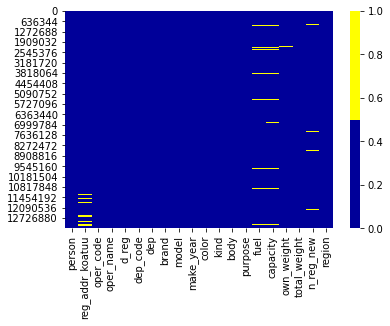

In [7]:
cols = data.columns
# визначаємо кольори
# жовтий - пропущені значення, синій - дійсні значення
colours = ['#000099', '#ffff00'] 
sns.heatmap(data[cols].isnull(), cmap=sns.color_palette(colours))

Переглядаємо статистику значень

In [8]:
for col in data.columns:
    pct_missing = np.mean(data[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

person - 0%
reg_addr_koatuu - 4%
oper_code - 0%
oper_name - 0%
d_reg - 0%
dep_code - 0%
dep - 0%
brand - 0%
model - 0%
make_year - 0%
color - 0%
kind - 0%
body - 0%
purpose - 0%
fuel - 5%
capacity - 6%
own_weight - 1%
total_weight - 0%
n_reg_new - 1%
region - 0%


Будуємо гістограму пропущених значень

created missing indicator for: reg_addr_koatuu
created missing indicator for: fuel
created missing indicator for: capacity
created missing indicator for: own_weight
created missing indicator for: total_weight
created missing indicator for: n_reg_new


<AxesSubplot:xlabel='index'>

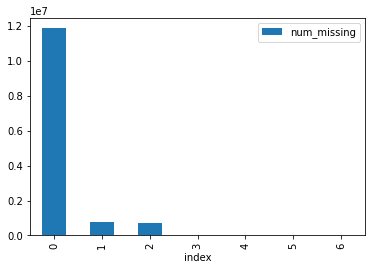

In [9]:
# будуємо індикатор для пропущених значень
for col in data.columns:
    missing = data[col].isnull()
    num_missing = np.sum(missing)
    
    if num_missing > 0:  
        print('created missing indicator for: {}'.format(col))
        data['{}_ismissing'.format(col)] = missing


# будуємо гістограму на основі індикатора
ismissing_cols = [col for col in data.columns if 'ismissing' in col]
data['num_missing'] = data[ismissing_cols].sum(axis=1)

data['num_missing'].value_counts().reset_index().sort_values(by='index').plot.bar(x='index', y='num_missing')

Продовжуємо досліджувати дані

In [10]:
#Перевіряємо види реєстрацій автомобілів
data["oper_name"].unique()

array(['40 - ВТОРИННА РЕЄСТРАЦІЯ ТЗ, ПРИДБАНОГО В ТОРГОВЕЛЬНІЙ ОРГАНІЗАЦІЇ',
       '230 -  ВИДАЧА СВ. ПРО РЕЄСТР ДЛЯ ПОЇЗДКИ ЗА КОРДОН ПО ДОРУЧ',
       '400 - ПЕРЕРЕЄСТРАЦIЯ ПРИ ПЕРЕОБЛАДНАННI БЕЗ ЗАМIНИ НОМЕРНИХ АГРЕГ.',
       '30 - ПЕРВИННА РЕЄСТРАЦІЯ ТЗ ДЛЯ ІНДИВ. ВЛАСНИКА',
       '440 - ПЕРЕРЕЄСТРАЦIЯ ПРИ ВТРАТІ СВIДОЦТВА ПРО РЕЄСТРАЦIЮ',
       '430 - ПЕРЕРЕЄСТРАЦІЯ ПРИ ЗАМІНІ СВІДОЦТВА ПРО РЕЄСТРАЦІЮ',
       '100 - ПЕРВИННА РЕЄСТРАЦIЯ ТЗ ПРИДБАНОГО В ТОРГІВЕЛЬНІЙ ОРГАНІЗАЦІЇ, УСТАНОВИ',
       '70 - РЕЄСТРАЦIЯ ТЗ ПРИВЕЗЕНОГО З-ЗА КОРДОНУ',
       '401 - ПЕРЕРЕЄСТРАЦІЯ ТЗ ПРИ ПЕРЕОБЛАДНАННІ ІЗ ЗАМІНОЮ КУЗОВА',
       '50 - РЕЄСТРАЦIЯ ТЗ ЗА ДОГОВОРОМ КУПIВЛI-ПРОДАЖУ',
       '11 - ПЕРВИННА РЕЄСТРАЦIЯ ТЗ ДЛЯ ІНШИХ ОРГ. ДЕРЖ.ВЛАСНОСТІ',
       '69 - РЕЄСТРАЦІЯ ТЗ ПО АКТУ ПРИЙОМУ-ПЕРЕДАЧІ',
       '350 - ПЕРЕРЕЄСТРАЦIЯ У ЗВ`ЯЗКУ ЗI ЗМIНОЮ НАЗВИ ОРГАНIЗАЦIЇ',
       '530 - ЗНЯТТЯ З ОБЛIКУ ДЛЯ РЕАЛIЗАЦIЇ',
       '80 - РЕЄСТРАЦIЯ ТЗ ПРИДБАНОГО НА АУКЦІОНІ ТОВАР. БIРЖI',
       '410

In [23]:
# видаляємо непотрібні атрибути
del data["reg_addr_koatuu"]
del data["oper_name"]
del data["dep_code"]
del data["dep"]
del data["capacity"]
del data["own_weight"]
del data["total_weight"]
del data["n_reg_new"]

In [11]:
data.head()

,person,oper_code,d_reg,brand,model,make_year,color,kind,body,purpose,fuel,region
0,P,40,2013-01-16,SSANG YONG REXTON,REXTON,2007,ЧОРНИЙ,ЛЕГКОВИЙ,УНІВЕРСАЛ-B,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,вінницька
1,P,230,2013-08-29,TOYOTA PREVIA,PREVIA,2007,СІРИЙ,ЛЕГКОВИЙ,УНІВЕРСАЛ-B,ЗАГАЛЬНИЙ,БЕНЗИН,одеська
2,P,40,2013-02-02,SKODA OCTAVIA,OCTAVIA,2011,БІЛИЙ,ЛЕГКОВИЙ,ХЕТЧБЕК-В,ЗАГАЛЬНИЙ,БЕНЗИН,дніпропетровська
3,P,400,2013-01-26,CITROEN JUMPY,JUMPY,2008,БІЛИЙ,ЛЕГКОВИЙ,ПАСАЖИРСЬКИЙ-B,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,тернопільська
4,P,400,2013-01-05,MERCEDES-BENZ SPRINTER 313 CDI,SPRINTER 313 CDI,2005,БІЛИЙ,ЛЕГКОВИЙ,ПАСАЖИРСЬКИЙ-B,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,тернопільська


In [24]:
# завантажуємо словник із інформацією про реєстраційні дії
oper_name_dict = pd.read_csv("oper_name.csv", sep = ";",encoding = "cp1251" )
oper_name_dict.head()

,oper_code,oper_name_new
0,541,УМОВНЕ ЗНЯТТЯ З ОБЛІКУ У ЗВ`ЯЗКУ З НЕПРОХОДЖЕН...
1,502,СКАСУВАННЯ ПЕРЕРЕЄСТРАЦІЇ
2,151,РЕЄСТРАЦІЯ ТЗ У ЗВ'ЯЗКУ ЗІ ЗМІНОЮ МІСЦЯ СТОЯНКИ
3,131,РЕЄСТРАЦІЯ ТЗ У ЗВ'ЯЗКУ З ПРИЇЗДОМ НА ПМЖ В МЕ...
4,71,РЕЄСТРАЦІЯ ТЗ ПРИВЕЗЕНОГО З


In [82]:
oper_name_dict

,oper_code,oper_name_new
0,541,УМОВНЕ ЗНЯТТЯ З ОБЛІКУ У ЗВ`ЯЗКУ З НЕПРОХОДЖЕН...
1,502,СКАСУВАННЯ ПЕРЕРЕЄСТРАЦІЇ
2,151,РЕЄСТРАЦІЯ ТЗ У ЗВ'ЯЗКУ ЗІ ЗМІНОЮ МІСЦЯ СТОЯНКИ
3,131,РЕЄСТРАЦІЯ ТЗ У ЗВ'ЯЗКУ З ПРИЇЗДОМ НА ПМЖ В МЕ...
4,71,РЕЄСТРАЦІЯ ТЗ ПРИВЕЗЕНОГО З
...,...,...
125,230,ВИДАЧА СВ. ПРО РЕЄСТР ДЛЯ ПОЇЗДКИ ЗА КОРДОН
126,470,ВИДАЧА ДУБЛІКАТУ ТИМЧ.ТАЛ.ДЛЯ МОПЕДІВ ПІСЛЯ ВТ...
127,501,АНУЛЮВАННЯ ЗНЯТТЯ З ОБЛІКУ ТЗ
128,255,АНУЛЮВАННЯ ВИДАЧI ТИМЧАС. РЕЄСТРАЦIЙНОГО ТАЛОН...


In [25]:
# додаємо очищені дані про реєстраційні дії до основного датасету
oper_name_dict["oper_code"] = oper_name_dict["oper_code"].astype(str)
data["oper_code"] = data["oper_code"].astype(str)
data = pd.merge(data,oper_name_dict, on='oper_code',how='left')
data

,person,oper_code,d_reg,brand,model,make_year,color,kind,body,purpose,fuel,region,oper_name_new
0,P,40,2013-01-16,SSANG YONG REXTON,REXTON,2007,ЧОРНИЙ,ЛЕГКОВИЙ,УНІВЕРСАЛ-B,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,вінницька,"ВТОРИННА РЕЄСТРАЦІЯ ТЗ, ПРИДБАНОГО В ТОРГОВЕЛЬ..."
1,P,230,2013-08-29,TOYOTA PREVIA,PREVIA,2007,СІРИЙ,ЛЕГКОВИЙ,УНІВЕРСАЛ-B,ЗАГАЛЬНИЙ,БЕНЗИН,одеська,ВИДАЧА СВ. ПРО РЕЄСТР ДЛЯ ПОЇЗДКИ ЗА КОРДОН
2,P,40,2013-02-02,SKODA OCTAVIA,OCTAVIA,2011,БІЛИЙ,ЛЕГКОВИЙ,ХЕТЧБЕК-В,ЗАГАЛЬНИЙ,БЕНЗИН,дніпропетровська,"ВТОРИННА РЕЄСТРАЦІЯ ТЗ, ПРИДБАНОГО В ТОРГОВЕЛЬ..."
3,P,400,2013-01-26,CITROEN JUMPY,JUMPY,2008,БІЛИЙ,ЛЕГКОВИЙ,ПАСАЖИРСЬКИЙ-B,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,тернопільська,ПЕРЕРЕЄСТРАЦIЯ ПРИ ПЕРЕОБЛАДНАННI
4,P,400,2013-01-05,MERCEDES-BENZ SPRINTER 313 CDI,SPRINTER 313 CDI,2005,БІЛИЙ,ЛЕГКОВИЙ,ПАСАЖИРСЬКИЙ-B,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,тернопільська,ПЕРЕРЕЄСТРАЦIЯ ПРИ ПЕРЕОБЛАДНАННI
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13363207,P,71,05.03.2021,SKODA,OCTAVIA COMBI,2002,СІРИЙ,ЛЕГКОВИЙ,УНІВЕРСАЛ,ЗАГАЛЬНИЙ,БЕНЗИН,хмельницька,РЕЄСТРАЦІЯ ТЗ ПРИВЕЗЕНОГО З
13363208,P,308,16.03.2021,HYUNDAI,SANTA FE,2007,ЧОРНИЙ,ЛЕГКОВИЙ,УНІВЕРСАЛ,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,вінницька,ПЕРЕРЕЄСТРАЦІЯ НА НОВОГО ВЛАСНИКА ЗА ДОГ. КУПIВЛI
13363209,P,71,05.03.2021,HYUNDAI,SANTA FE,2007,ЧОРНИЙ,ЛЕГКОВИЙ,УНІВЕРСАЛ,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,вінницька,РЕЄСТРАЦІЯ ТЗ ПРИВЕЗЕНОГО З
13363210,P,308,30.03.2021,FORD,C-MAX,2014,БІЛИЙ,ЛЕГКОВИЙ,УНІВЕРСАЛ,ЗАГАЛЬНИЙ,ЕЛЕКТРО АБО БЕНЗИН,донецька,ПЕРЕРЕЄСТРАЦІЯ НА НОВОГО ВЛАСНИКА ЗА ДОГ. КУПIВЛI


In [26]:
# створюємо новий стовпець із глобальним статусом
data["oper_name_new"] = data["oper_name_new"].str.replace(r'.*ЗНЯТТЯ.*', r"ЗНЯТТЯ", regex = True)
data["oper_name_new"] = data["oper_name_new"].str.replace(r'.*ПЕРВИННА.*', r"ПЕРВИННА", regex = True)

,person,oper_code,d_reg,brand,model,make_year,color,kind,body,purpose,fuel,region,oper_name_new
0,P,40,2013-01-16,SSANG YONG REXTON,REXTON,2007,ЧОРНИЙ,ЛЕГКОВИЙ,УНІВЕРСАЛ-B,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,вінницька,"ВТОРИННА РЕЄСТРАЦІЯ ТЗ, ПРИДБАНОГО В ТОРГОВЕЛЬ..."
1,P,230,2013-08-29,TOYOTA PREVIA,PREVIA,2007,СІРИЙ,ЛЕГКОВИЙ,УНІВЕРСАЛ-B,ЗАГАЛЬНИЙ,БЕНЗИН,одеська,ВИДАЧА СВ. ПРО РЕЄСТР ДЛЯ ПОЇЗДКИ ЗА КОРДОН
2,P,40,2013-02-02,SKODA OCTAVIA,OCTAVIA,2011,БІЛИЙ,ЛЕГКОВИЙ,ХЕТЧБЕК-В,ЗАГАЛЬНИЙ,БЕНЗИН,дніпропетровська,"ВТОРИННА РЕЄСТРАЦІЯ ТЗ, ПРИДБАНОГО В ТОРГОВЕЛЬ..."
3,P,400,2013-01-26,CITROEN JUMPY,JUMPY,2008,БІЛИЙ,ЛЕГКОВИЙ,ПАСАЖИРСЬКИЙ-B,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,тернопільська,ПЕРЕРЕЄСТРАЦIЯ ПРИ ПЕРЕОБЛАДНАННI
4,P,400,2013-01-05,MERCEDES-BENZ SPRINTER 313 CDI,SPRINTER 313 CDI,2005,БІЛИЙ,ЛЕГКОВИЙ,ПАСАЖИРСЬКИЙ-B,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,тернопільська,ПЕРЕРЕЄСТРАЦIЯ ПРИ ПЕРЕОБЛАДНАННI
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13363207,P,71,05.03.2021,SKODA,OCTAVIA COMBI,2002,СІРИЙ,ЛЕГКОВИЙ,УНІВЕРСАЛ,ЗАГАЛЬНИЙ,БЕНЗИН,хмельницька,РЕЄСТРАЦІЯ ТЗ ПРИВЕЗЕНОГО З
13363208,P,308,16.03.2021,HYUNDAI,SANTA FE,2007,ЧОРНИЙ,ЛЕГКОВИЙ,УНІВЕРСАЛ,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,вінницька,ПЕРЕРЕЄСТРАЦІЯ НА НОВОГО ВЛАСНИКА ЗА ДОГ. КУПIВЛI
13363209,P,71,05.03.2021,HYUNDAI,SANTA FE,2007,ЧОРНИЙ,ЛЕГКОВИЙ,УНІВЕРСАЛ,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,вінницька,РЕЄСТРАЦІЯ ТЗ ПРИВЕЗЕНОГО З
13363210,P,308,30.03.2021,FORD,C-MAX,2014,БІЛИЙ,ЛЕГКОВИЙ,УНІВЕРСАЛ,ЗАГАЛЬНИЙ,ЕЛЕКТРО АБО БЕНЗИН,донецька,ПЕРЕРЕЄСТРАЦІЯ НА НОВОГО ВЛАСНИКА ЗА ДОГ. КУПIВЛI


In [27]:
data.head()

,person,oper_code,d_reg,brand,model,make_year,color,kind,body,purpose,fuel,region,oper_name_new
0,P,40,2013-01-16,SSANG YONG REXTON,REXTON,2007,ЧОРНИЙ,ЛЕГКОВИЙ,УНІВЕРСАЛ-B,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,вінницька,"ВТОРИННА РЕЄСТРАЦІЯ ТЗ, ПРИДБАНОГО В ТОРГОВЕЛЬ..."
1,P,230,2013-08-29,TOYOTA PREVIA,PREVIA,2007,СІРИЙ,ЛЕГКОВИЙ,УНІВЕРСАЛ-B,ЗАГАЛЬНИЙ,БЕНЗИН,одеська,ВИДАЧА СВ. ПРО РЕЄСТР ДЛЯ ПОЇЗДКИ ЗА КОРДОН
2,P,40,2013-02-02,SKODA OCTAVIA,OCTAVIA,2011,БІЛИЙ,ЛЕГКОВИЙ,ХЕТЧБЕК-В,ЗАГАЛЬНИЙ,БЕНЗИН,дніпропетровська,"ВТОРИННА РЕЄСТРАЦІЯ ТЗ, ПРИДБАНОГО В ТОРГОВЕЛЬ..."
3,P,400,2013-01-26,CITROEN JUMPY,JUMPY,2008,БІЛИЙ,ЛЕГКОВИЙ,ПАСАЖИРСЬКИЙ-B,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,тернопільська,ПЕРЕРЕЄСТРАЦIЯ ПРИ ПЕРЕОБЛАДНАННI
4,P,400,2013-01-05,MERCEDES-BENZ SPRINTER 313 CDI,SPRINTER 313 CDI,2005,БІЛИЙ,ЛЕГКОВИЙ,ПАСАЖИРСЬКИЙ-B,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,тернопільська,ПЕРЕРЕЄСТРАЦIЯ ПРИ ПЕРЕОБЛАДНАННI


# Аналіз

Завантажуємо дані пілся OpenRefine
та проводимо left join many-to-one

In [28]:
brand_splited = pd.read_excel("brand_splited.xlsx")
brand_splited = brand_splited[["brand", "brand_new"]]
brand_splited = brand_splited.set_index("brand")
brand_splited

,brand_new
brand,
0,0
SSANG YONG REXTON,SSANG YONG
TOYOTA PREVIA,TOYOTA
SKODA OCTAVIA,SKODA
CITROEN JUMPY,CITROEN
...,...
FSC,FSC
BULTMANN,BULTMANN
HAKO,HAKO


In [29]:
data = pd.merge(data,brand_splited, on='brand',how='left')

In [30]:
data.head()

,person,oper_code,d_reg,brand,model,make_year,color,kind,body,purpose,fuel,region,oper_name_new,brand_new
0,P,40,2013-01-16,SSANG YONG REXTON,REXTON,2007,ЧОРНИЙ,ЛЕГКОВИЙ,УНІВЕРСАЛ-B,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,вінницька,"ВТОРИННА РЕЄСТРАЦІЯ ТЗ, ПРИДБАНОГО В ТОРГОВЕЛЬ...",SSANG YONG
1,P,230,2013-08-29,TOYOTA PREVIA,PREVIA,2007,СІРИЙ,ЛЕГКОВИЙ,УНІВЕРСАЛ-B,ЗАГАЛЬНИЙ,БЕНЗИН,одеська,ВИДАЧА СВ. ПРО РЕЄСТР ДЛЯ ПОЇЗДКИ ЗА КОРДОН,TOYOTA
2,P,40,2013-02-02,SKODA OCTAVIA,OCTAVIA,2011,БІЛИЙ,ЛЕГКОВИЙ,ХЕТЧБЕК-В,ЗАГАЛЬНИЙ,БЕНЗИН,дніпропетровська,"ВТОРИННА РЕЄСТРАЦІЯ ТЗ, ПРИДБАНОГО В ТОРГОВЕЛЬ...",SKODA
3,P,400,2013-01-26,CITROEN JUMPY,JUMPY,2008,БІЛИЙ,ЛЕГКОВИЙ,ПАСАЖИРСЬКИЙ-B,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,тернопільська,ПЕРЕРЕЄСТРАЦIЯ ПРИ ПЕРЕОБЛАДНАННI,CITROEN
4,P,400,2013-01-05,MERCEDES-BENZ SPRINTER 313 CDI,SPRINTER 313 CDI,2005,БІЛИЙ,ЛЕГКОВИЙ,ПАСАЖИРСЬКИЙ-B,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,тернопільська,ПЕРЕРЕЄСТРАЦIЯ ПРИ ПЕРЕОБЛАДНАННI,MERCEDES-BENZ


### топ __нових__ реєстрацій автомобілів за маркою

In [31]:
# скидаємо індекс для того, щоб отримати унікальний ідентифікатор
data.reset_index(inplace = True)

In [33]:
# робимо сабсет даних для візуалізації
barplot_brands = data[["brand_new","oper_code","person", "kind", "make_year"]]
barplot_brands = barplot_brands.loc[
    barplot_brands["oper_code"].isin(["30", "100", "11", "20", "10", "120", "99", "172", "105", "17"])] # фільтруємо ті реєстраційні операції, які нам потрібні

barplot_brands = barplot_brands.loc[
    barplot_brands["person"] == "P"] # вибираємо тип покупця, в даному випадку фізичні особи

barplot_brands = barplot_brands.loc[
    barplot_brands["kind"] == "ЛЕГКОВИЙ"] # вибираємо тип автомобіля

barplot_brands = barplot_brands.loc[
    barplot_brands["make_year"] >= 2000] # обираємо рік випуску автомобіля

# робимо зведену таблицю для простоти візуалізації
barplot_brands = pd.pivot_table(barplot_brands, index = "brand_new", aggfunc="count")
barplot_brands = barplot_brands.sort_values("oper_code", ascending = False) #сортуємо дані в порядку спадання

Посилання на документацію https://seaborn.pydata.org/generated/seaborn.barplot.html

In [34]:
# індекс, який ми отримали через сводну таблицю, для того щоб побудувати графік (при зміні налаштувань графіка застосовується лише раз)
barplot_brands.reset_index(inplace = True)

[Text(0.5, 1.0, 'Рейтинг найпопулярніших марок авто в Україні')]

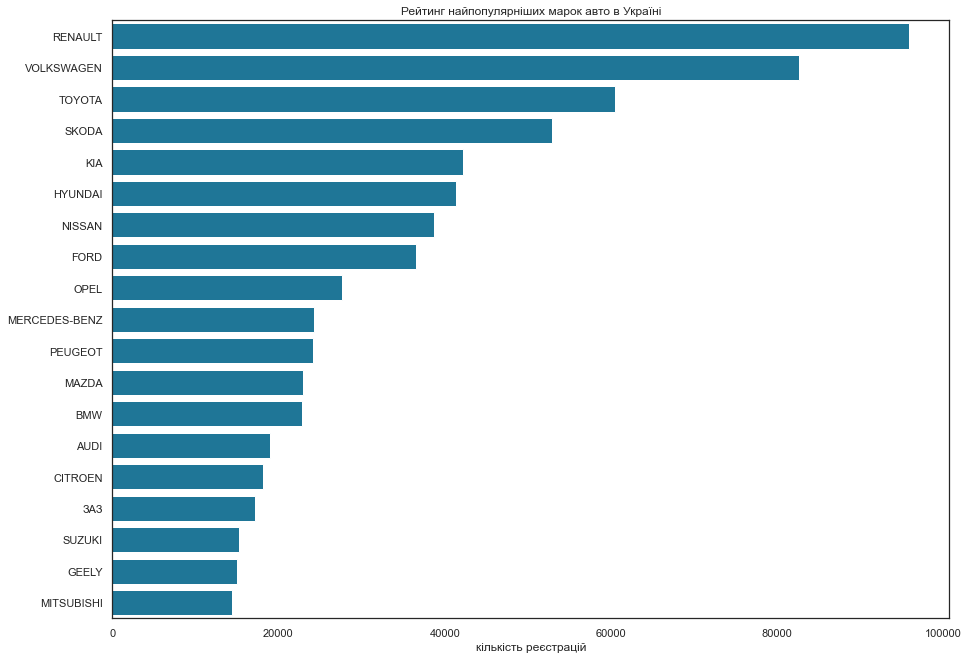

In [36]:
barplot = sns.barplot(
    data=barplot_brands.iloc[:19], # Кількість записів у ТОП, можемо редагувати під час оголошення графіку
    x="oper_code",
    y = "brand_new",
    color="#0b7fab",
)

sns.set_theme(
    style = "white",
    rc={'figure.figsize':(15,11)}
)

barplot.set(xlabel ='кількість реєстрацій', ylabel='')
barplot.set(title = "Рейтинг найпопулярніших марок авто в Україні")

### топ __нових__ реєстрацій автомобілв за моделлю фізичні особи

In [37]:
# об'єднуємо стовпчик "марка" та "модель" для отримання унікальних записів
data["brand_model"] = data[["brand_new", "model"]].apply(tuple, axis=1)
data.head()

,index,person,oper_code,d_reg,brand,model,make_year,color,kind,body,purpose,fuel,region,oper_name_new,brand_new,brand_model
0,0,P,40,2013-01-16,SSANG YONG REXTON,REXTON,2007,ЧОРНИЙ,ЛЕГКОВИЙ,УНІВЕРСАЛ-B,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,вінницька,"ВТОРИННА РЕЄСТРАЦІЯ ТЗ, ПРИДБАНОГО В ТОРГОВЕЛЬ...",SSANG YONG,"(SSANG YONG, REXTON)"
1,1,P,230,2013-08-29,TOYOTA PREVIA,PREVIA,2007,СІРИЙ,ЛЕГКОВИЙ,УНІВЕРСАЛ-B,ЗАГАЛЬНИЙ,БЕНЗИН,одеська,ВИДАЧА СВ. ПРО РЕЄСТР ДЛЯ ПОЇЗДКИ ЗА КОРДОН,TOYOTA,"(TOYOTA, PREVIA)"
2,2,P,40,2013-02-02,SKODA OCTAVIA,OCTAVIA,2011,БІЛИЙ,ЛЕГКОВИЙ,ХЕТЧБЕК-В,ЗАГАЛЬНИЙ,БЕНЗИН,дніпропетровська,"ВТОРИННА РЕЄСТРАЦІЯ ТЗ, ПРИДБАНОГО В ТОРГОВЕЛЬ...",SKODA,"(SKODA, OCTAVIA)"
3,3,P,400,2013-01-26,CITROEN JUMPY,JUMPY,2008,БІЛИЙ,ЛЕГКОВИЙ,ПАСАЖИРСЬКИЙ-B,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,тернопільська,ПЕРЕРЕЄСТРАЦIЯ ПРИ ПЕРЕОБЛАДНАННI,CITROEN,"(CITROEN, JUMPY)"
4,4,P,400,2013-01-05,MERCEDES-BENZ SPRINTER 313 CDI,SPRINTER 313 CDI,2005,БІЛИЙ,ЛЕГКОВИЙ,ПАСАЖИРСЬКИЙ-B,ЗАГАЛЬНИЙ,ДИЗЕЛЬНЕ ПАЛИВО,тернопільська,ПЕРЕРЕЄСТРАЦIЯ ПРИ ПЕРЕОБЛАДНАННI,MERCEDES-BENZ,"(MERCEDES-BENZ, SPRINTER 313 CDI)"


In [38]:
model_j = pd.pivot_table(data, index = "brand_model", aggfunc="count")
model_j = model_j.sort_values("body", ascending = False)
model_j.head()

,body,brand,brand_new,color,d_reg,fuel,index,kind,make_year,model,oper_code,oper_name_new,person,purpose,region
brand_model,,,,,,,,,,,,,,,
"(DAEWOO, LANOS)",240153,240153,240153,240153,240153,239901,240153,240153,240153,240153,240153,239865,240153,240153,240153
"(VOLKSWAGEN, PASSAT)",219811,219811,219811,219811,219811,219661,219811,219811,219811,219811,219811,219327,219811,219811,219811
"(VOLKSWAGEN, TRANSPORTER)",186791,186791,186791,186791,186791,186791,186791,186791,186791,186791,186791,186560,186791,186791,186791
"(RENAULT, KANGOO)",168290,168290,168290,168290,168290,168270,168290,168290,168290,168290,168290,168117,168290,168290,168290
"(CHEVROLET, AVEO)",165162,165162,165162,165162,165162,165161,165162,165162,165162,165162,165162,164888,165162,165162,165162


In [39]:
# треба скинути індекс, який ми отримали через сводну таблицю, для того щоб побудувати графік (при зміні налаштувань графіка застосовується лише раз)
model_j.reset_index(inplace = True)

[Text(0.5, 0, 'Кількість реєстрацій'), Text(0, 0.5, '')]

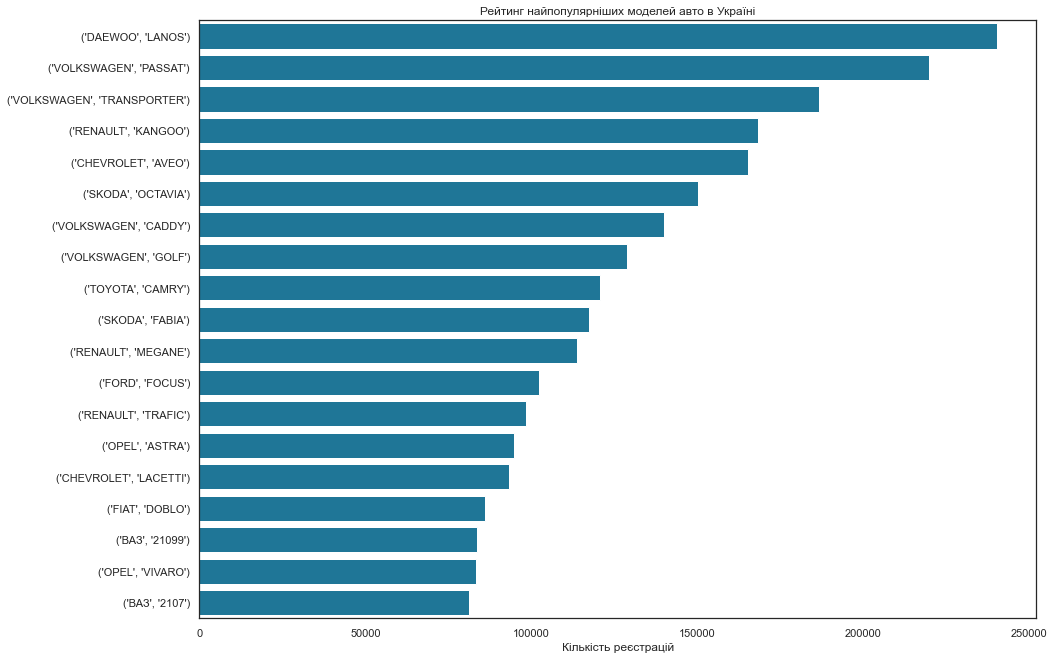

In [40]:
barplot = sns.barplot(
    data=model_j.iloc[:19], # Кількість записів у ТОП, можемо редагувати під час оголошення графіку
    x="body",
    y = "brand_model",
    color="#0b7fab",
)

sns.set_theme(
    style = "white",
    rc={'figure.figsize':(15,11)}
)

barplot.set(title = "Рейтинг найпопулярніших моделей авто в Україні")
barplot.set(xlabel ='Кількість реєстрацій', ylabel='')

### Порівняння на лайнчарті кількості __нових__ реєстрацій АВТО за весь час з 2013 року

In [49]:
linechart_registrations = data[["brand_new","oper_code","person", "kind", "d_reg"]]
linechart_registrations["oper_code"] = linechart_registrations["oper_code"].astype(str)
linechart_registrations["d_reg"] = pd.to_datetime(linechart_registrations["d_reg"])
linechart_registrations = linechart_registrations.loc[
    linechart_registrations["oper_code"].isin(["30", "100", "11", "20", "10", "99", "172", "105", "17"])] # фільтруємо ті реєстраційні операції, які нам потрібні

linechart_registrations = linechart_registrations.loc[
    linechart_registrations["person"] == "P"] # вибираємо тип покупця, в даному випадку фізичні особи

linechart_registrations = linechart_registrations.loc[
    linechart_registrations["kind"] == "ЛЕГКОВИЙ"] # вибираємо тип автомобіля

linechart_registrations = pd.pivot_table(linechart_registrations, index = "d_reg",aggfunc="count" )
#linechart_registrations['cum_sum'] = linechart_registrations['brand_new'].cumsum()
linechart_registrations.reset_index(inplace = True)

<ipython-input-49-0d490aaf3c99>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  linechart_registrations["oper_code"] = linechart_registrations["oper_code"].astype(str)
<ipython-input-49-0d490aaf3c99>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  linechart_registrations["d_reg"] = pd.to_datetime(linechart_registrations["d_reg"])


In [58]:
# агрегуємо інформацію по місяцях
linechart_registrations["y_m"] = pd.to_datetime(linechart_registrations["d_reg"]).dt.strftime("%Y-%m")
linechart_registrations["y_m"] = pd.to_datetime(linechart_registrations["y_m"])
linechart_registrations

,d_reg,brand_new,kind,oper_code,person,y_m
0,2013-01-02,141,141,141,141,2013-01-01
1,2013-01-03,189,189,189,189,2013-01-01
2,2013-01-04,122,122,122,122,2013-01-01
3,2013-01-05,101,101,101,101,2013-01-01
4,2013-01-08,224,224,224,224,2013-01-01
...,...,...,...,...,...,...
2525,2021-11-02,575,575,575,575,2021-11-01
2526,2021-11-03,860,860,860,860,2021-11-01
2527,2021-12-01,875,875,875,875,2021-12-01
2528,2021-12-02,538,538,538,538,2021-12-01


[Text(0.5, 0, ''), Text(0, 0.5, '')]

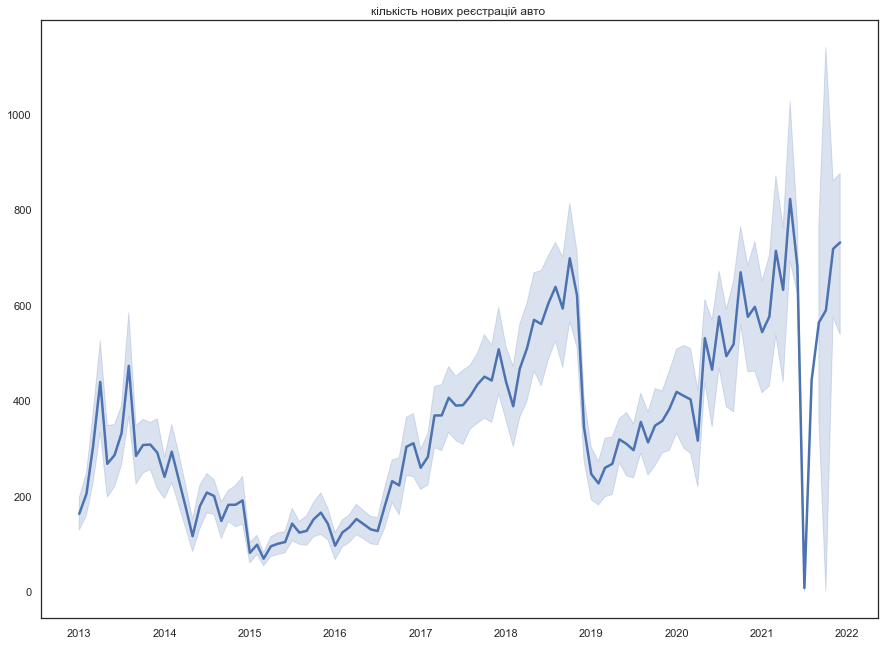

In [59]:
lines = sns.lineplot(data=linechart_registrations, x = "y_m", y = "brand_new", linewidth=2.5)
lines.set(title = "кількість нових реєстрацій авто ")
lines.set(xlabel ='', ylabel='')

### Порівняння на лайнчарті кількості __нових__ реєстрацій АВТО за весь час з 2013 року (варіант 2)

In [77]:
# створ.ємо зведену таблицю по місяцями
linechart_registrations = pd.pivot_table(linechart_registrations, index = "y_m",aggfunc="count" )

In [78]:
# скидаємо індекс
linechart_registrations.reset_index(inplace = True)

In [80]:
linechart_registrations

,y_m,brand_new,d_reg,kind,oper_code,person,region
0,2013-01-01,394,394,394,394,394,394
1,2013-02-01,380,380,380,380,380,380
2,2013-03-01,403,403,403,403,403,403
3,2013-04-01,426,426,426,426,426,426
4,2013-05-01,391,391,391,391,391,391
...,...,...,...,...,...,...,...
103,2021-08-01,25,25,25,25,25,25
104,2021-09-01,50,50,50,50,50,50
105,2021-10-01,51,51,51,51,51,51
106,2021-11-01,50,50,50,50,50,50


[Text(0.5, 0, ''), Text(0, 0.5, '')]

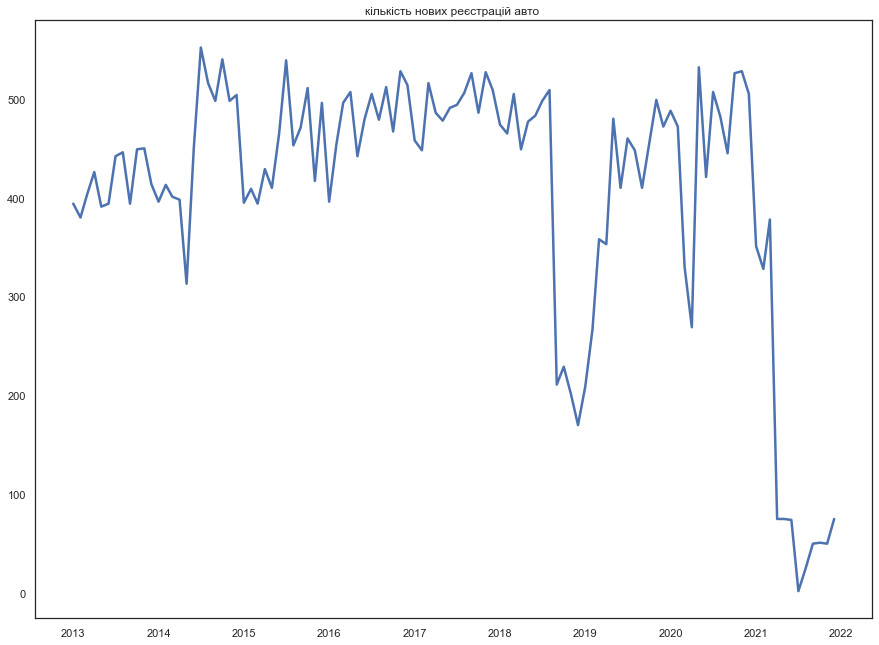

In [79]:
lines = sns.lineplot(data=linechart_registrations, x = "y_m", y = "brand_new", linewidth=2.5)
lines.set(title = "кількість нових реєстрацій авто ")
lines.set(xlabel ='', ylabel='')

### Порівняння кількості реєстрацій та кількості зняття з реєстрації

In [60]:
linechart_registrations = data[["brand_new","oper_code", "person", "kind", "d_reg", "oper_name_new"]] # створюємо копію із датасету з потрібними полями 

linechart_registrations["oper_code"] = linechart_registrations["oper_code"].astype(str) # змінюємо тип коду реєстрації на текстовий

linechart_registrations["oper_name_new"] = linechart_registrations["oper_name_new"].astype(str) # змінюємо тип коду реєстрації на текстовий

linechart_registrations["d_reg"] = pd.to_datetime(linechart_registrations["d_reg"]) # перетвлрюємо дату реєстрації на дату
linechart_registrations = linechart_registrations.loc[
    linechart_registrations["oper_code"].isin([
        "30", "100", "11", "20", "10", "99",
        "172", "105", "17", "552", "553", "53", "536",
        "542", "570", "500", "554", "580", "560", "510",
        "535", "534", "540", "550", "561", "520", "532",
        "531", "533", "530"])] # фільтруємо ті реєстраційні операції, які нам потрібні

linechart_registrations = linechart_registrations.loc[
    linechart_registrations["person"] == "P"] # вибираємо тип покупця, в даному випадку фізичні особи

linechart_registrations = linechart_registrations.loc[
    linechart_registrations["kind"] == "ЛЕГКОВИЙ"] # вибираємо тип автомобіля

linechart_registrations = pd.pivot_table(linechart_registrations, index = ["oper_name_new", "d_reg"] ,aggfunc="count" ) # створюємо зведену таблицю
linechart_registrations['cum_sum'] = linechart_registrations['brand_new'].cumsum() # створюємо стовпич із кумулятивною сумою
linechart_registrations.reset_index(inplace = True) # прибераємо індекс


<ipython-input-60-58c06ddef5f0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  linechart_registrations["oper_code"] = linechart_registrations["oper_code"].astype(str) # змінюємо тип коду реєстрації на текстовий
<ipython-input-60-58c06ddef5f0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  linechart_registrations["oper_name_new"] = linechart_registrations["oper_name_new"].astype(str) # змінюємо тип коду реєстрації на текстовий
<ipython-input-60-58c06ddef5f0>:7: SettingWithCopyWarning: 
A value is trying 

In [61]:
linechart_registrations

,oper_name_new,d_reg,brand_new,kind,oper_code,person,cum_sum
0,ЗНЯТТЯ,2013-01-02,370,370,370,370,370
1,ЗНЯТТЯ,2013-01-03,720,720,720,720,1090
2,ЗНЯТТЯ,2013-01-04,524,524,524,524,1614
3,ЗНЯТТЯ,2013-01-05,457,457,457,457,2071
4,ЗНЯТТЯ,2013-01-07,2,2,2,2,2073
...,...,...,...,...,...,...,...
5072,ПЕРВИННА,2021-11-02,575,575,575,575,1918855
5073,ПЕРВИННА,2021-11-03,860,860,860,860,1919715
5074,ПЕРВИННА,2021-12-01,875,875,875,875,1920590
5075,ПЕРВИННА,2021-12-02,538,538,538,538,1921128


[Text(0.5, 0, ''), Text(0, 0.5, '')]

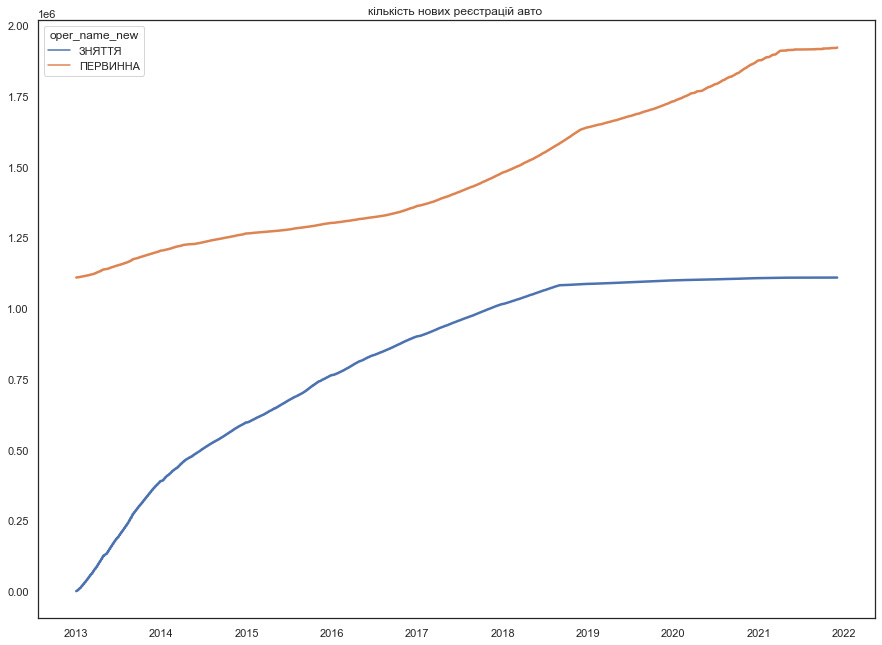

In [62]:
lines = sns.lineplot(data=linechart_registrations, x = "d_reg", y = "cum_sum", linewidth=2.5, hue="oper_name_new")
lines.set(title = "кількість нових реєстрацій авто ")
lines.set(xlabel ='', ylabel='')

### Сітка лайн чартів із порівнянням кількості __нових__ реєстрацій по областях

In [63]:
# Create a dataset with many short random walks
linechart_registrations = data[["brand_new","oper_code","person", "kind", "d_reg", "region"]]
linechart_registrations["oper_code"] = linechart_registrations["oper_code"].astype(str)
linechart_registrations["d_reg"] = pd.to_datetime(linechart_registrations["d_reg"])

linechart_registrations = linechart_registrations.loc[
    linechart_registrations["oper_code"].isin(["30", "100", "11", "20", "10", "120", "99"])] # фільтруємо ті реєстраційні операції, які нам потрібні

linechart_registrations = linechart_registrations.loc[
    linechart_registrations["person"] == "P"] # вибираємо тип покупця, в даному випадку фізичні особи

linechart_registrations = linechart_registrations.loc[
    linechart_registrations["kind"] == "ЛЕГКОВИЙ"] # вибираємо тип автомобіля

linechart_registrations = pd.pivot_table(linechart_registrations, index = ["d_reg", "region"],aggfunc="count" )
linechart_registrations

<ipython-input-63-6f73622f9502>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  linechart_registrations["oper_code"] = linechart_registrations["oper_code"].astype(str)
<ipython-input-63-6f73622f9502>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  linechart_registrations["d_reg"] = pd.to_datetime(linechart_registrations["d_reg"])


brand_new  kind  oper_code  person
d_reg      region                                               
2013-01-02 вінницька                  8     8          8       8
           дніпропетровська           5     5          5       5
           донецька                  39    39         39      39
           житомирська                2     2          2       2
           закарпатська               1     1          1       1
...                                 ...   ...        ...     ...
2021-12-03 хмельницька               17    17         17      17
           черкаська                 10    10         10      10
           чернівецька                9     9          9       9
           чернігівська              19    19         19      19
           івано-франківська         11    11         11      11

[44087 rows x 4 columns]

In [71]:
# треба скинути індекс, який ми отримали через сводну таблицю, для того щоб побудувати графік (при зміні налаштувань графіка застосовується лише раз)
linechart_registrations.reset_index(inplace = True)
linechart_registrations

,d_reg,region,brand_new,kind,oper_code,person
0,2013-01-02,вінницька,8,8,8,8
1,2013-01-02,дніпропетровська,5,5,5,5
2,2013-01-02,донецька,39,39,39,39
3,2013-01-02,житомирська,2,2,2,2
4,2013-01-02,закарпатська,1,1,1,1
...,...,...,...,...,...,...
44082,2021-12-03,хмельницька,17,17,17,17
44083,2021-12-03,черкаська,10,10,10,10
44084,2021-12-03,чернівецька,9,9,9,9
44085,2021-12-03,чернігівська,19,19,19,19


In [74]:
# агрегуємо інформацію по місяцях
linechart_registrations["y_m"] = pd.to_datetime(linechart_registrations["d_reg"]).dt.strftime("%Y-%m")
linechart_registrations["y_m"] = pd.to_datetime(linechart_registrations["y_m"])
linechart_registrations

,d_reg,region,brand_new,kind,oper_code,person,y_m
0,2013-01-02,вінницька,8,8,8,8,2013-01-01
1,2013-01-02,дніпропетровська,5,5,5,5,2013-01-01
2,2013-01-02,донецька,39,39,39,39,2013-01-01
3,2013-01-02,житомирська,2,2,2,2,2013-01-01
4,2013-01-02,закарпатська,1,1,1,1,2013-01-01
...,...,...,...,...,...,...,...
44082,2021-12-03,хмельницька,17,17,17,17,2021-12-01
44083,2021-12-03,черкаська,10,10,10,10,2021-12-01
44084,2021-12-03,чернівецька,9,9,9,9,2021-12-01
44085,2021-12-03,чернігівська,19,19,19,19,2021-12-01


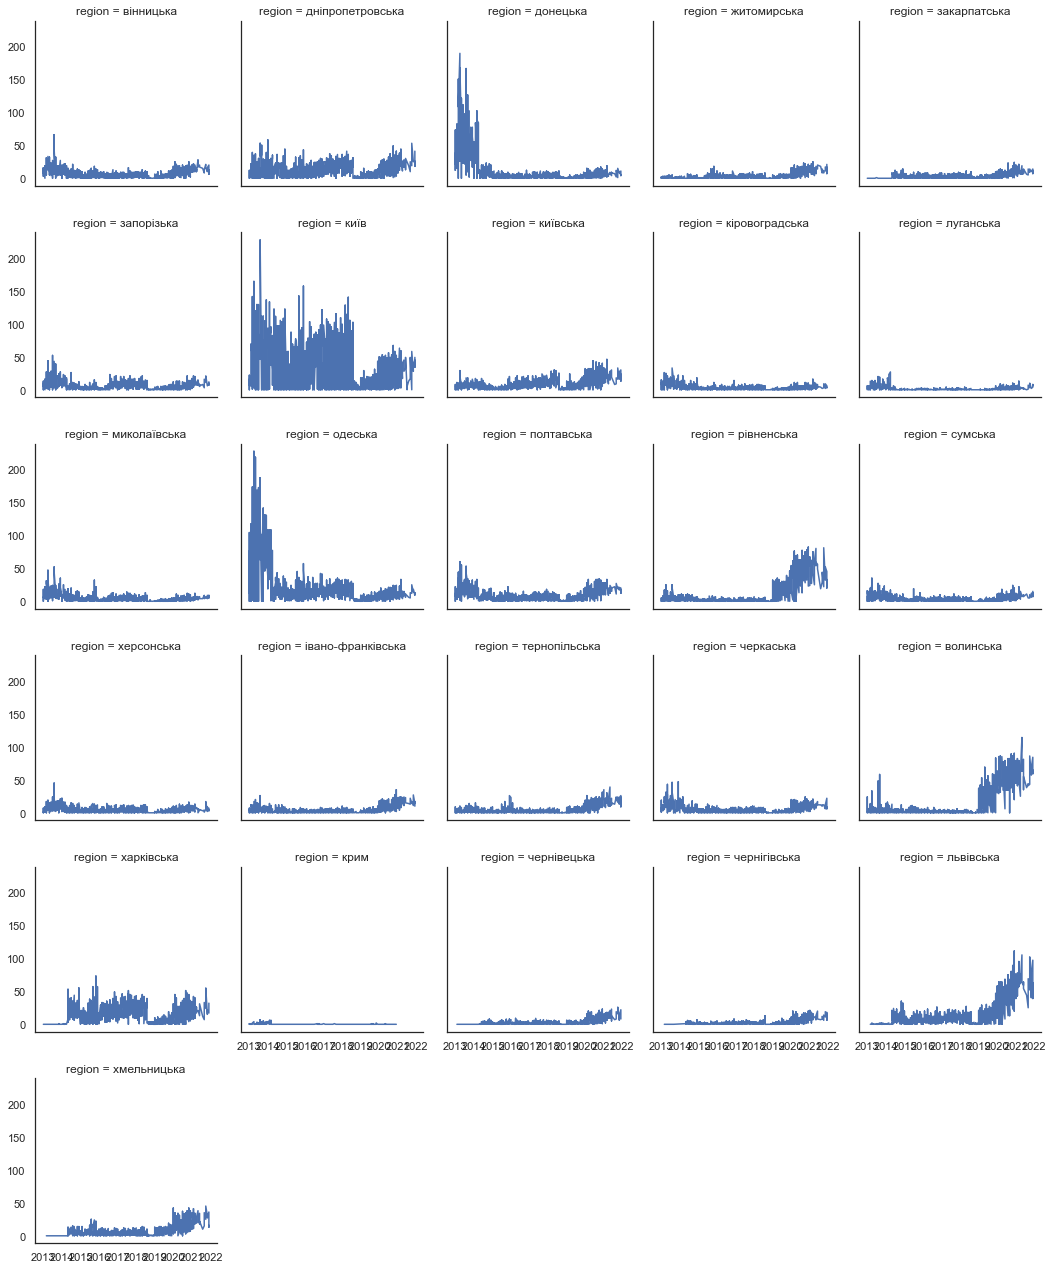

In [75]:
# ініціюємо сітку графіків для кожного регіону
grid = sns.FacetGrid(linechart_registrations, col="region", col_wrap=5, height=3)

grid.map(plt.plot, "y_m", "brand_new")
grid.set(xlabel ='', ylabel='')